In [206]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

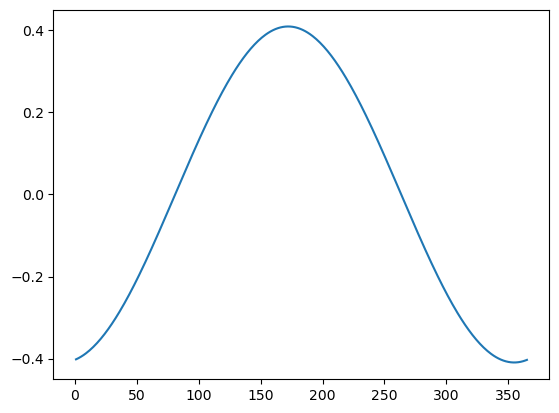

In [207]:
N = np.arange(1, 366, 1)

delta = (23.45 * np.sin(
        (360/365 * (284 + N)) / 360 * 2 * np.pi
        )) / 360 * 2 * np.pi

plt.plot(N, delta)

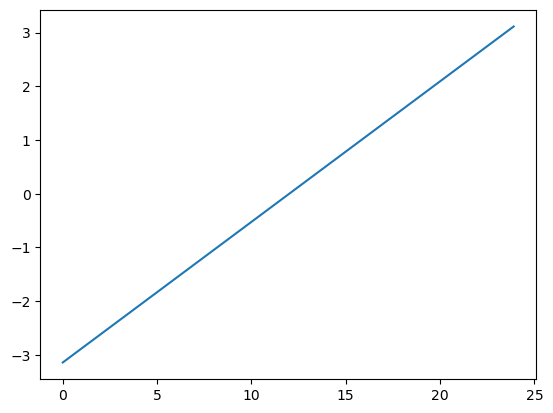

In [208]:
local_hour_of_day = np.arange(0, 24, 0.1)

h = (((local_hour_of_day - 12) % 24)/24) * 2 * np.pi

mask = np.nonzero(h>=np.pi)

h[mask] = -((2*np.pi)-h[mask])

plt.plot(local_hour_of_day, h)

In [422]:
# timestamps = pd.date_range('2023-01-01', '2023-01-05', freq='1h', inclusive='left')
# timestamps = pd.date_range('2023-07-01', '2023-07-05', freq='1h', inclusive='left')
timestamps = pd.date_range('2023-01-01', '2024-01-01', freq='1h', inclusive='left')
# timestamps = pd.date_range('2023-05-01', '2023-05-10', freq='1h', inclusive='left')
# timestamps = pd.date_range('2023-08-01', '2023-08-10', freq='1h', inclusive='left')


print(len(timestamps))


8760


In [431]:
latitude = 70  # degrees
surface_azimuth_angle = 0
angle = 45

Method 1 (file:///C:/Users/bruij_kn/Downloads/7.1_Solar_Radiation_on_Inclined_Surfaces%20(1).pdf)

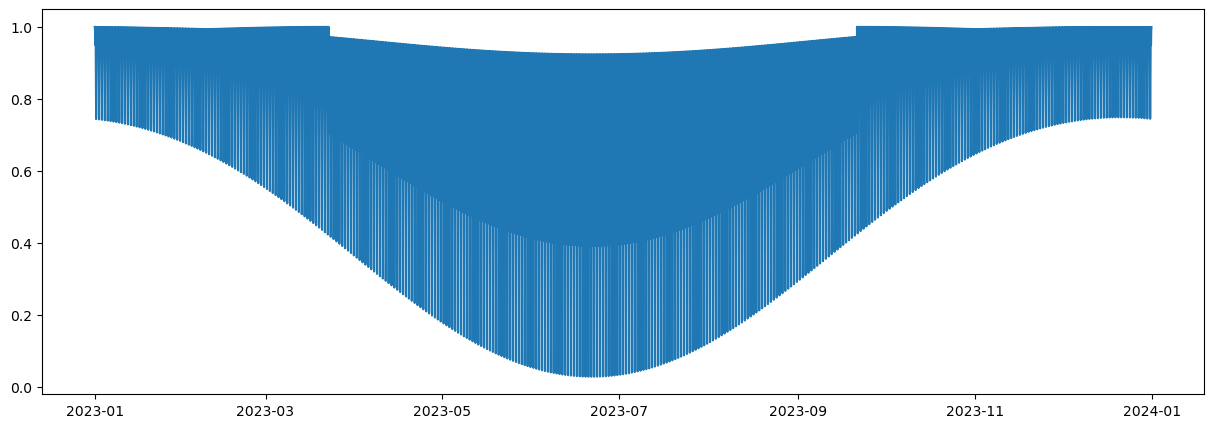

In [432]:
beta = angle / 360 * 2 * np.pi

# latitude
phi = latitude / 360 * 2 * np.pi

# declination, Sarbu (2017)
delta = (23.45 * np.sin(
    (360/365 * (284 + timestamps.dayofyear.values)) / 360 * 2 * np.pi
    )) / 360 * 2 * np.pi

# hour angle, for Alaska timezone difference w.r.t. UTC is -8h
local_hour_of_day = timestamps.hour.values #+ timezone_diff
# convert to hour angle
h = (((local_hour_of_day - 12) % 24)/24) * 2 * np.pi
mask = np.nonzero(h>=np.pi)
h[mask] = -((2 * np.pi) - h[mask])

# solar altitude
a = np.arcsin(np.cos(phi) * np.cos(delta) * np.cos(h) + np.sin(phi) * np.sin(delta))

value = ((np.sin(a) * np.sin(phi) - np.sin(delta)) / (np.cos(a) * np.cos(phi)))

mask_pos = np.nonzero(value>1)
value[mask_pos] = 1

mask_neg = np.nonzero(value<-1)
value[mask_neg] = -1

solar_azimuth = np.arccos(value) * np.sign(h)

gamma = solar_azimuth - surface_azimuth_angle
gamma_mask = np.nonzero((gamma>1/2*np.pi) * (gamma<3/2*np.pi) + (gamma>-3/2*np.pi) * (gamma<-1/2*np.pi))
gamma[gamma_mask] = 0

theta = np.arccos(np.cos(a) * np.cos(np.abs(gamma)) * np.sin(beta) + np.sin(a) * np.cos(beta))

factor = np.sin(theta)

plt.figure(figsize=(15,5))

plt.plot(timestamps, factor)

plt.show()

plt.close()


Method 2: “Central Beaufort Sea Wave and Hydrodynamic Modeling Study Report 1: Field Measurements and Model Development,” n.d.

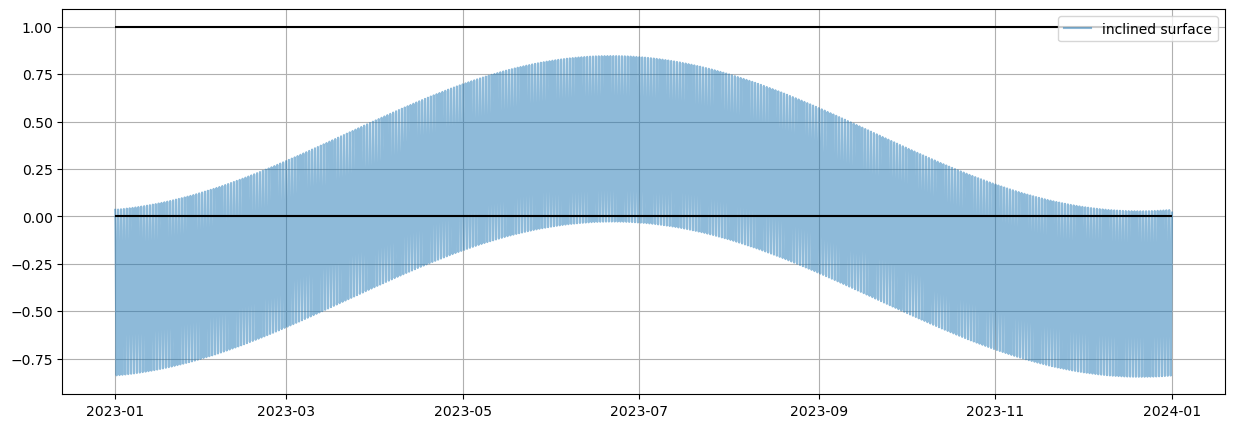

In [437]:
# latitude
phi = latitude / 360 * 2 * np.pi
alpha = angle / 360 * 2 * np.pi
beta = surface_azimuth_angle / 360 * 2 * np.pi

# declination, Sarbu (2017)
delta = (23.45 * np.sin(
    (360/365 * (284 + timestamps.dayofyear.values)) / 360 * 2 * np.pi
    )) / 360 * 2 * np.pi

# hour angle, for Alaska timezone difference w.r.t. UTC is -8h
local_hour_of_day = timestamps.hour.values #+ timezone_diff
# convert to hour angle
h = (((local_hour_of_day - 12) % 24)/24) * 2 * np.pi
mask = np.nonzero(h>=np.pi)
h[mask] = -((2 * np.pi) - h[mask])

A = np.arcsin(np.sin(phi) * np.sin(delta) + np.cos(phi) * np.cos(delta) * np.cos(h))

AZ = np.arcsin(np.cos(delta) * (np.sin(h)) / np.cos(A))

ew_AM_mask = np.nonzero((np.cos(h) < np.tan(delta) / np.tan(phi)) * (local_hour_of_day <= 12))  # east-west AM mask
ew_PM_mask = np.nonzero((np.cos(h) < np.tan(delta) / np.tan(phi)) * (local_hour_of_day > 12)) # east-west PM mask

AZ[ew_AM_mask] = -np.pi + np.abs(AZ[ew_AM_mask])
AZ[ew_PM_mask] = np.pi - AZ[ew_PM_mask]

# Z = np.arcsin(np.cos(delta) * np.sin(h) / np.cos(A)) + 1/2 * np.pi
Z = AZ + 1/2 * np.pi


sin_theta = np.sin(A) * np.cos(alpha) - np.cos(A) * np.sin(alpha) * np.sin(Z - beta)
# sin_theta[np.nonzero(sin_theta>1)] = 1
# sin_theta[np.nonzero(sin_theta<0)] = 0

sin_0 = np.sin(A) * np.cos(0) - np.cos(A) * np.sin(0) * np.sin(Z - beta)
# sin_0[np.nonzero(sin_0>1)] = 1
# sin_0[np.nonzero(sin_0<0)] = 0

# theta = np.arcsin(sin_theta)

# zero_mask = np.nonzero(sin_theta <= 0)

# sin_theta[zero_mask] = 0

plt.figure(figsize=(15,5))

plt.plot(timestamps, np.arcsin(sin_theta), label='inclined surface', alpha=0.5)
# plt.plot(timestamps, sin_0, label='flat surface', linestyle='dashed', alpha=0.5)

plt.legend()

plt.hlines([0, 1], xmin = np.min(timestamps), xmax = np.max(timestamps), color='k')

plt.grid(visible=True, which='both', rasterized=True)

plt.show()

plt.close()

Method 3: similar to method 2 but uses new formula for theta from environmental characteristics.

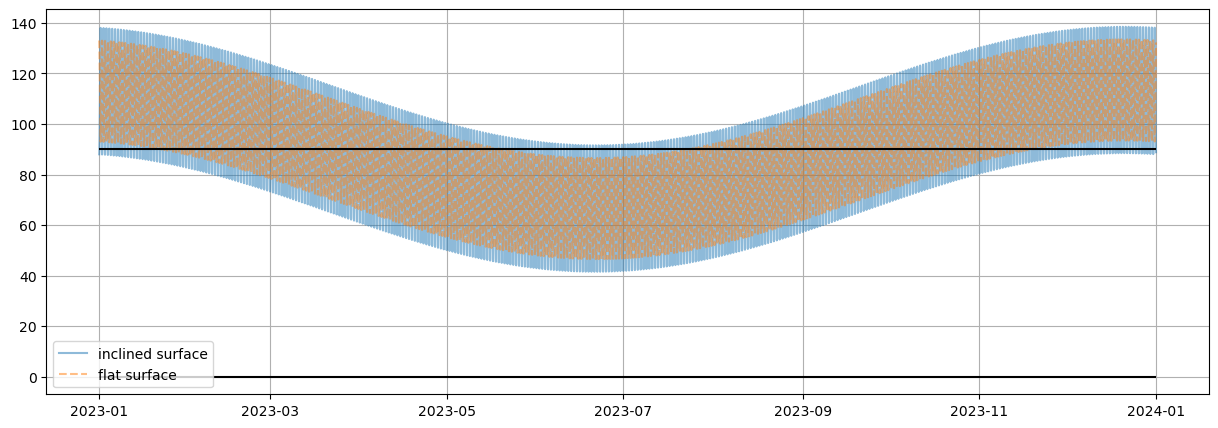

In [434]:
# latitude
L = latitude / 360 * 2 * np.pi
beta = angle / 360 * 2 * np.pi
Zs = (180 + surface_azimuth_angle) / 360 * 2 * np.pi

# declination, Sarbu (2017)
delta = (23.45 * np.sin(
    (360/365 * (284 + timestamps.dayofyear.values)) / 360 * 2 * np.pi
    )) / 360 * 2 * np.pi

# hour angle, for Alaska timezone difference w.r.t. UTC is -8h
local_hour_of_day = timestamps.hour.values #+ timezone_diff
# convert to hour angle
h = (((local_hour_of_day - 12) % 24)/24) * 2 * np.pi
mask = np.nonzero(h>=np.pi)
h[mask] = -((2 * np.pi) - h[mask])

A = np.arcsin(np.sin(phi) * np.sin(delta) + np.cos(phi) * np.cos(delta) * np.cos(h))

z = np.arcsin(np.cos(delta) * (np.sin(h)) / np.cos(A))

ew_AM_mask = np.nonzero((np.cos(h) < np.tan(delta) / np.tan(phi)) * (local_hour_of_day <= 12))  # east-west AM mask
ew_PM_mask = np.nonzero((np.cos(h) < np.tan(delta) / np.tan(phi)) * (local_hour_of_day > 12)) # east-west PM mask

z[ew_AM_mask] = -np.pi + np.abs(z[ew_AM_mask])
z[ew_PM_mask] = np.pi - z[ew_PM_mask]

# Zs = z

cos_theta = np.sin(L) * np.sin(delta) * np.cos(beta) - np.cos(L) * np.sin(delta) * np.sin(beta) * np.cos(Zs) \
    + np.cos(L) * np.cos(delta) * np.cos(h) * np.cos(beta) + np.sin(L) * np.cos(delta) * np.cos(h) * np.sin(beta) * np.cos(Zs) \
    + np.cos(delta) * np.sin(h) * np.sin(beta) * np.sin(Zs)


# sin_theta[np.nonzero(sin_theta>1)] = 1
# sin_theta[np.nonzero(sin_theta<0)] = 0

beta = 0
cos_0 = np.sin(L) * np.sin(delta) * np.cos(beta) - np.cos(L) * np.sin(delta) * np.sin(beta) * np.cos(Zs) \
    + np.cos(L) * np.cos(delta) * np.cos(h) * np.cos(beta) + np.sin(L) * np.cos(delta) * np.cos(h) * np.sin(beta) * np.cos(Zs) \
    + np.cos(delta) * np.sin(h) * np.sin(beta) * np.sin(Zs)
    
sin_theta = np.sin(np.arccos(cos_theta))
sin_0 = np.sin(np.arccos(cos_0))

# sin_0[np.nonzero(sin_0>1)] = 1
# sin_0[np.nonzero(sin_0<0)] = 0

# theta = np.arcsin(sin_theta)

# zero_mask = np.nonzero(sin_theta <= 0)

# sin_theta[zero_mask] = 0

plt.figure(figsize=(15,5))

plt.plot(timestamps, np.arccos(cos_theta) / np.pi * 180, label='inclined surface', alpha=0.5)
plt.plot(timestamps, np.arccos(cos_0) / np.pi * 180, label='flat surface', linestyle='dashed', alpha=0.5)

plt.legend()

plt.hlines([0, 90], xmin = np.min(timestamps), xmax = np.max(timestamps), color='k')

plt.grid(visible=True, which='both', rasterized=True)

plt.show()

plt.close()

365
8760


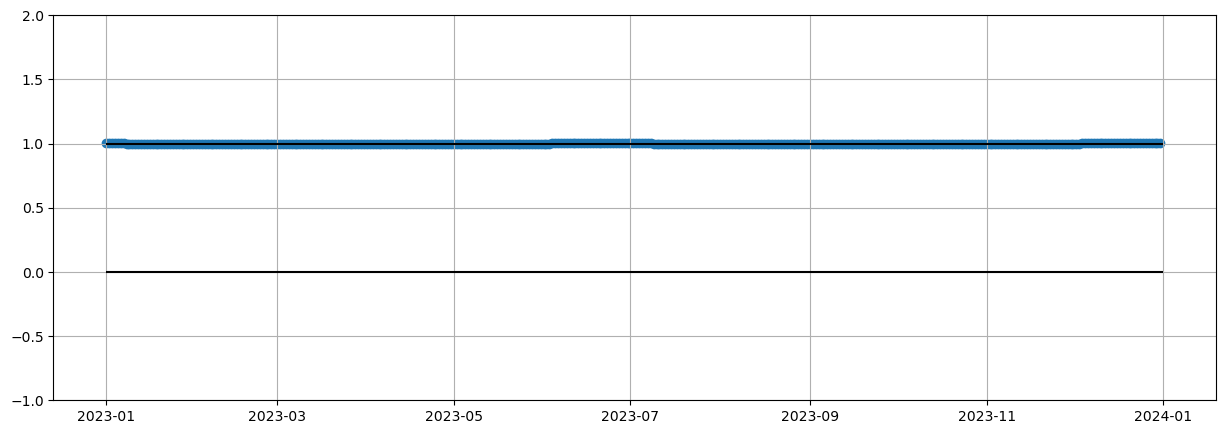

In [435]:

sin_theta_2d = sin_theta.reshape((-1, 24))
sin_theta_daily_max_2d = np.max(sin_theta_2d, axis=1).flatten()
# sin_theta_daily_max = np.repeat(sin_theta_daily_max_2d.flatten(), 24)

sin_0_2d = sin_0.reshape((-1, 24))
sin_0_daily_max_2d = np.max(sin_0_2d, axis=1).flatten()
# sin_0_daily_max = np.repeat(sin_0_daily_max_2d.flatten(), 24)

quotient = sin_theta_daily_max_2d/sin_0_daily_max_2d

print(len(quotient))
print(len(timestamps))
# filter out values where either of the angles is negative
quotient[np.nonzero(sin_theta_daily_max_2d<0)] = 0
quotient[np.nonzero(sin_0_daily_max_2d<0)] = 0

plt.figure(figsize=(15,5))

plt.scatter(timestamps[::24,], quotient)

plt.hlines([0, 1], xmin = np.min(timestamps), xmax = np.max(timestamps), color='k')

plt.grid(visible=True, which='both', rasterized=True)
# plt.ylim((-50, 50))
# plt.ylim((-1, 10))
plt.ylim((-1, 2))

plt.show()

plt.close()


In [436]:
# # sun_down_mask = (sin_theta0 <= 0) + (sin_theta <= 0)

# # restrict_size_mask = 

# # mask1 = np.nonzero(sin_theta==0)
# # mask2 = np.nonzero(sin_theta0)

# # quotient = sin_theta / sin_theta0

# # quotient[sun_down_mask] = 0

# plt.figure(figsize=(15,5))

# plt.plot(timestamps, quotient)

# plt.hlines([0, 1], xmin = np.min(timestamps), xmax = np.max(timestamps), color='k')

# plt.grid(visible=True, which='both', rasterized=True)
# # plt.ylim((-50, 50))
# # plt.ylim((-1, 2))

# plt.show()

# plt.close()

# print(np.sum(np.isnan(quotient)))

In [429]:
# plt.figure(figsize=(15,5))

# plt.plot(timestamps, quotient)

# plt.hlines([0, 1], xmin = np.min(timestamps), xmax = np.max(timestamps), color='k')

# plt.grid(visible=True, which='both', rasterized=True)

# plt.show()

# plt.close()


In [430]:
import xarray as xr

In [181]:
ds = xr.open_dataset("mean_surface_net_short_wave_radiation_flux_2020.nc")

ds_masked = ds.where((ds.longitude==190.0) & (ds.latitude==75.0), drop=True)

t_start = pd.to_datetime("2020-05-01")
t_end   = pd.to_datetime("2020-05-10")

ds_masked = ds_masked.where((ds_masked.time > t_start) & (ds_masked.time < t_end), drop=True)

ds.close()

print(ds_masked)

<xarray.Dataset> Size: 3kB
Dimensions:    (time: 215, latitude: 1, longitude: 1)
Coordinates:
  * longitude  (longitude) float32 4B 190.0
  * latitude   (latitude) float32 4B 75.0
  * time       (time) datetime64[ns] 2kB 2020-05-01T01:00:00 ... 2020-05-09T2...
Data variables:
    msnswrf    (time, latitude, longitude) float64 2kB 51.66 54.15 ... 63.63
Attributes:
    Conventions:  CF-1.6
    history:      2024-04-17 00:03:41 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...


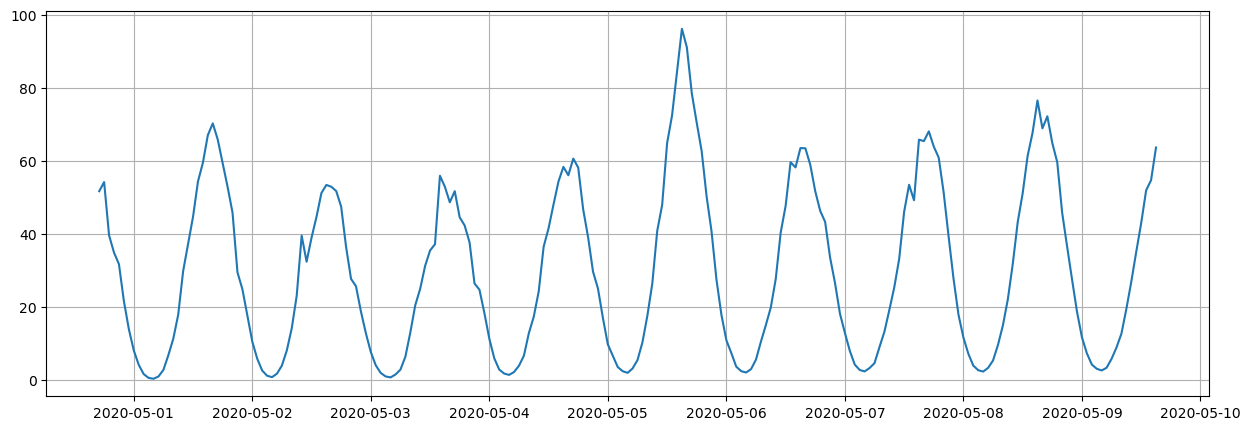

In [184]:
plt.figure(figsize=(15,5))

plt.plot(ds_masked.time.values - pd.to_timedelta('8h'), ds_masked.msnswrf.values.flatten())

plt.grid(visible=True, which='both', rasterized=True)

plt.show()

plt.close()

In [185]:
x = np.linspace(0, 10, 10)
y = -np.sqrt(x)

np.gradient(y, x)

array([-0.9486833 , -0.67082039, -0.34724219, -0.2778629 , -0.23907634,
       -0.21321171, -0.19432987, -0.17974578, -0.16803491, -0.16276832])

In [180]:
dic = {}

dic['a'] = 1
dic['b'] = 2

print(dic)

for key in dic:
    print(key, dic[key])

{'a': 1, 'b': 2}
a 1
b 2


In [193]:
t_start = pd.to_datetime('2019-01-01')
t_end = pd.to_datetime('2020-01-01')

t = pd.date_range(t_start, t_end, freq='1h', inclusive='left')

print(len(t)/24)



365.0


In [360]:
local_hour_of_day = .01

h = (((local_hour_of_day - 12) % 24)/24) * 2 * np.pi
if h >= np.pi:
    h = -((2 * np.pi) - h)

print(h)

-3.138974659711802
